<a href="https://colab.research.google.com/github/sungjuGit/STPython_IntroBayes/blob/main/LangOfModel_LinReg_FirstLook_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted from the Julia code using Claude.ai

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pymc as pm
import arviz as az
from scipy.stats import norm, lognorm, uniform
import random

In [ ]:
# Helper function for getting credibility interval
def CredI(d, p=0.95):
    return [np.quantile(d, (1-p)/2), np.quantile(d, (1+p)/2)]

In [ ]:
# Load data
d = pd.read_csv("Howell1.csv", delimiter=';')

In [ ]:
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [ ]:
# Select only adults
d2 = d[d.age >= 18]

In [ ]:
# Descriptive statistics
print(d2.describe())

           height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


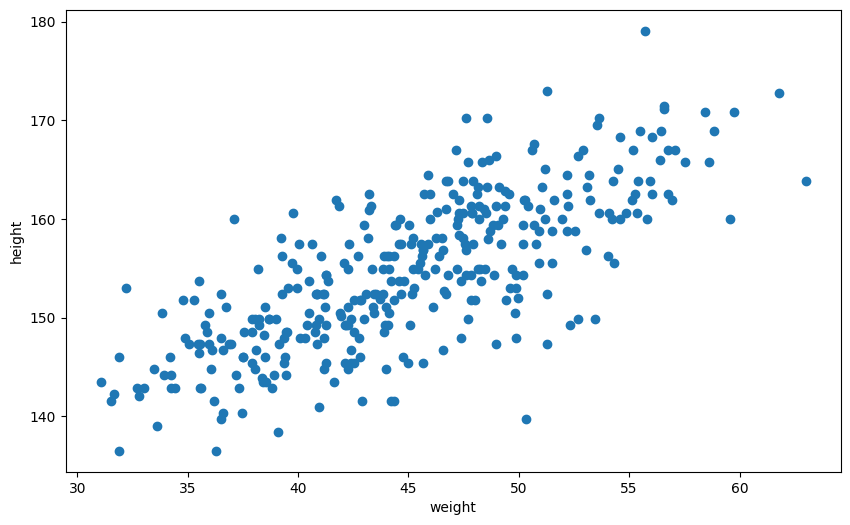

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(d2.weight, d2.height)
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

In [ ]:
# Calculate means
x_bar = np.mean(d2.weight)
h_bar = np.mean(d2.height)

In [ ]:
# Get min and max for plotting purposes
xlims = (d2.weight.min(), d2.weight.max())
ylims = (d2.height.min(), d2.height.max())

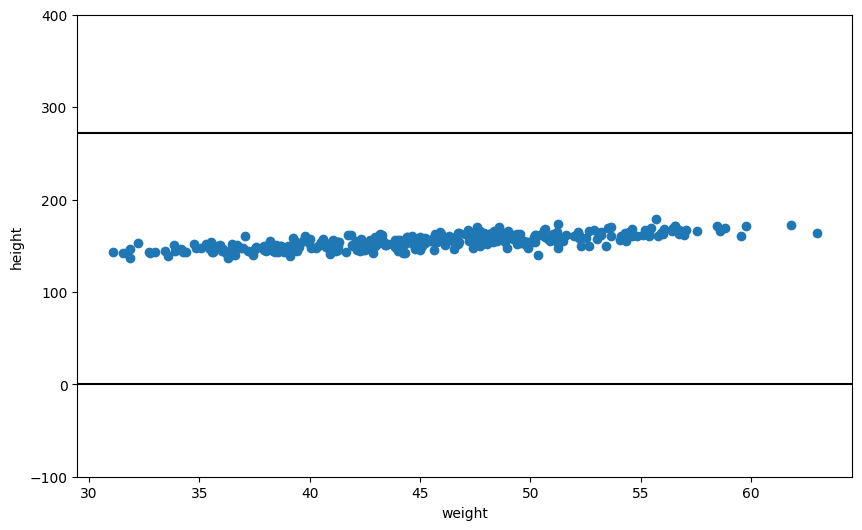

In [ ]:
# Plot with normal distributions for α and β
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=272, color='black', linestyle='-')
plt.ylim(-100, 400)
plt.xlabel("weight")
plt.ylabel("height")
plt.scatter(d2.weight, d2.height)

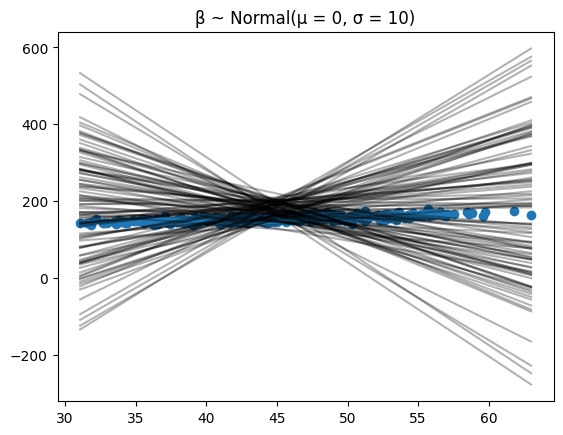

In [ ]:
# See what the normal distributions for α and β give
random.seed(2971)
N = 100
alpha = np.random.normal(178, 20, N)
beta = np.random.normal(0, 10, N)

x_range = np.linspace(xlims[0], xlims[1], 100)
for a, b in zip(alpha, beta):
    y = a + b * (x_range - x_bar)
    plt.plot(x_range, y, color='black', alpha=0.3)

plt.title("β ~ Normal(μ = 0, σ = 10)")
plt.scatter(d2.weight, d2.height)
plt.show()

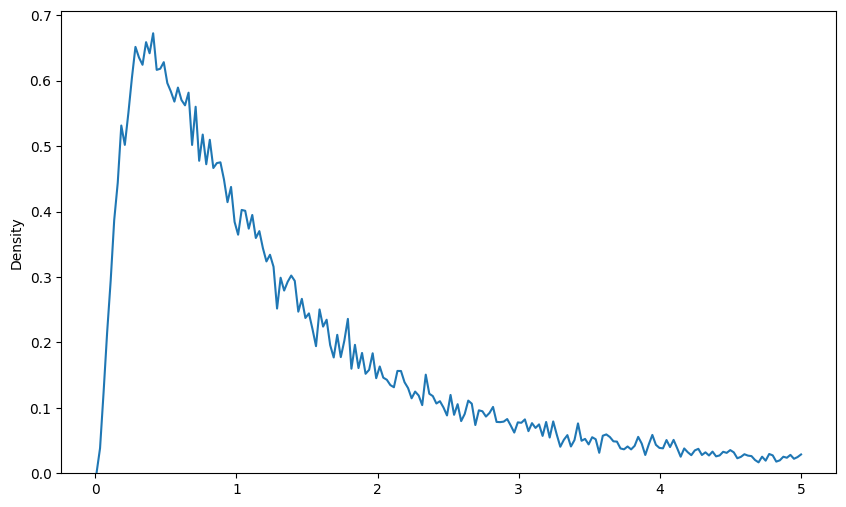

In [ ]:
# Generate lognormal distribution for β
beta = np.random.lognormal(0, 1, 100000)
plt.figure(figsize=(10, 6))
sns.kdeplot(beta, clip=(0, 5), bw_adjust=0.01)
plt.show()


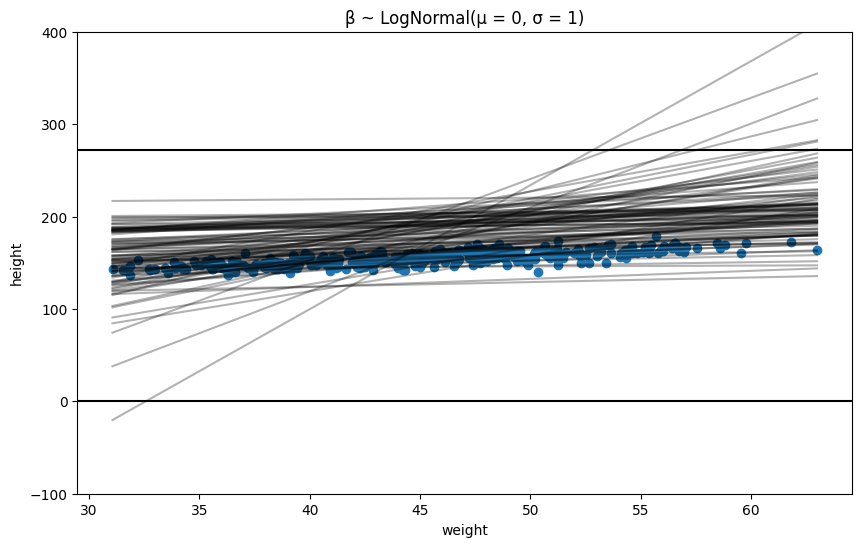

In [ ]:
# See what the log-normal distribution for β gives
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=272, color='black', linestyle='-')
plt.ylim(-100, 400)
plt.xlabel("weight")
plt.ylabel("height")
plt.title("β ~ LogNormal(μ = 0, σ = 1)")

x_range = np.linspace(xlims[0], xlims[1], 100)
for a, b in zip(alpha, beta[:100]):  # Using just the first 100 samples
    y = a + b * (x_range - x_bar)
    plt.plot(x_range, y, color='black', alpha=0.3)

plt.scatter(d2.weight, d2.height)
plt.show()

In [ ]:
# Define Bayesian model for linear regression using PyMC
with pm.Model() as height_regr_model:
    # Priors
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.LogNormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Expected value of outcome
    mu = alpha + beta * (d2.weight.values - x_bar)

    # Likelihood (sampling distribution) of observations
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=d2.height.values)

    # Inference
    trace = pm.sample(1000, return_inferencedata=True)

Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

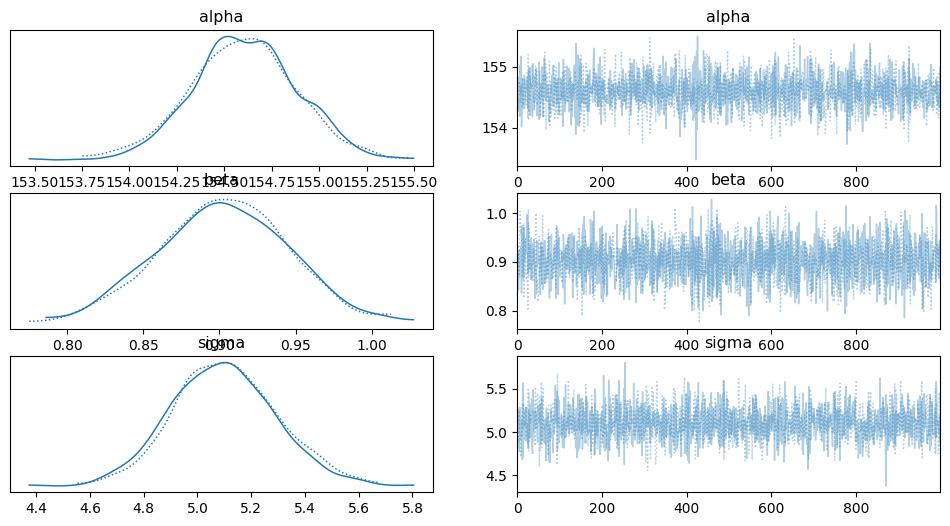

In [ ]:
az.plot_trace(trace)

In [ ]:
# Convert samples to DataFrame
samples_df = az.summary(trace)
print(samples_df)

          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha  154.605  0.275  154.102  155.142      0.006    0.008    2212.0   
beta     0.902  0.042    0.827    0.981      0.001    0.001    2750.0   
sigma    5.102  0.191    4.770    5.487      0.004    0.004    2346.0   

       ess_tail  r_hat  
alpha    1341.0    1.0  
beta     1591.0    1.0  
sigma    1517.0    1.0  


In [ ]:
alpha_mean = samples_df.loc['alpha', 'mean']
beta_mean = samples_df.loc['beta', 'mean']

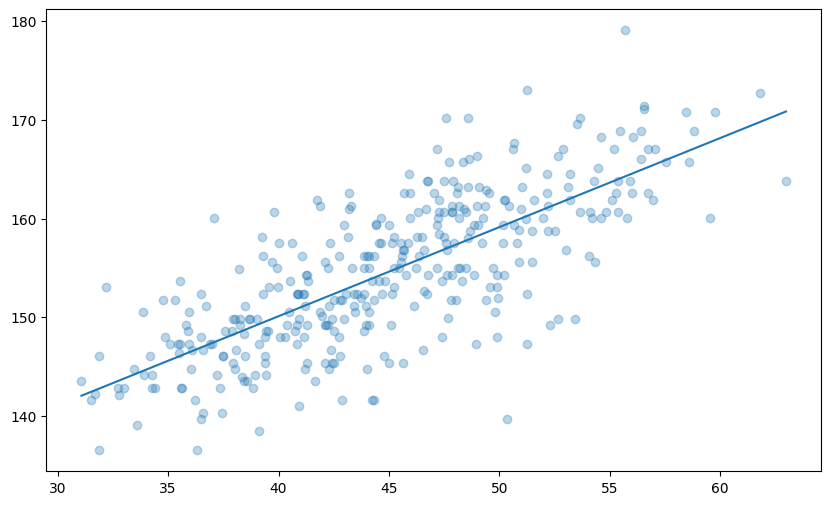

In [ ]:
# Plot with posterior means
plt.figure(figsize=(10, 6))
plt.scatter(d2.weight, d2.height, alpha=0.3)
plt.plot(x_range, alpha_mean + beta_mean * (x_range - x_bar))
plt.show()

Output()

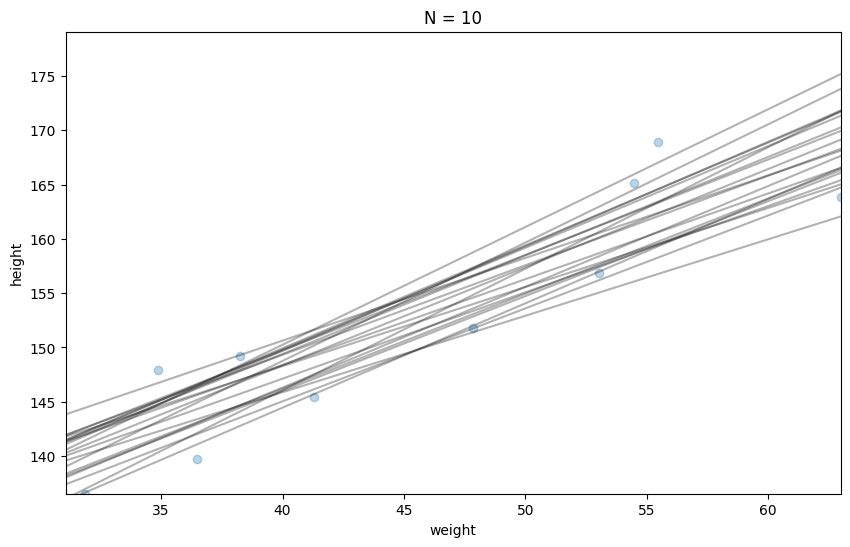

Output()

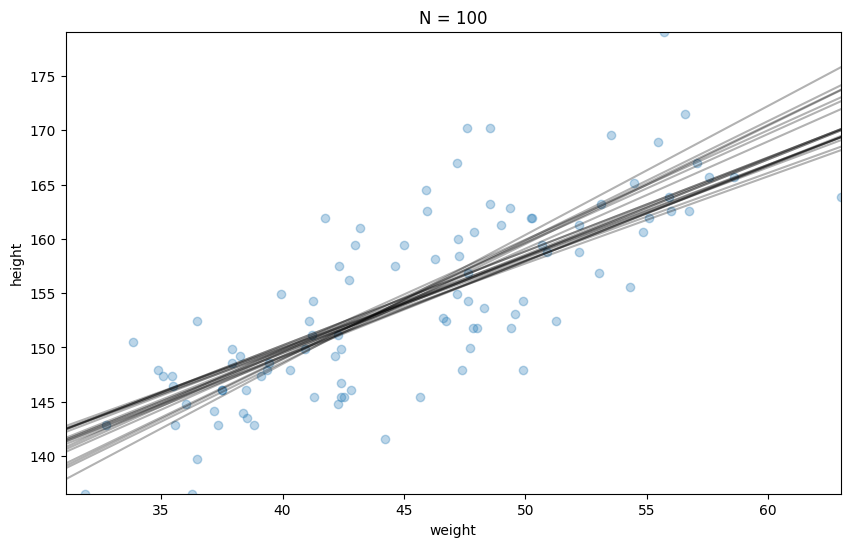

In [ ]:
# Reduced sample sizes to explore posterior distributions
for N in [10, 100]:
    dN = d2.iloc[:N]
    x_bar_N = np.mean(dN.weight)

    with pm.Model() as reduced_model:
        # Priors
        alpha = pm.Normal('alpha', mu=178, sigma=20)
        beta = pm.LogNormal('beta', mu=0, sigma=1)
        sigma = pm.Uniform('sigma', lower=0, upper=50)

        # Expected value of outcome
        mu = alpha + beta * (dN.weight.values - x_bar_N)

        # Likelihood (sampling distribution) of observations
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=dN.height.values)

        # Inference
        trace_N = pm.sample(1000, return_inferencedata=True)

    # Plot with posterior samples
    plt.figure(figsize=(10, 6))
    plt.scatter(dN.weight, dN.height, alpha=0.3)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title(f"N = {N}")
    plt.xlabel("weight")
    plt.ylabel("height")

    # Extract samples
    posterior = trace_N.posterior
    alpha_samples = posterior.alpha.values.flatten()
    beta_samples = posterior.beta.values.flatten()

    # Plot 20 posterior lines
    for a, b in zip(alpha_samples[:20], beta_samples[:20]):
        y = a + b * (x_range - x_bar_N)
        plt.plot(x_range, y, color='black', alpha=0.3)

    plt.show()

In [ ]:
# Return to original model and take 1000 samples
posterior = trace.posterior
alpha_samples = posterior.alpha.values.flatten()
beta_samples = posterior.beta.values.flatten()
sigma_samples = posterior.sigma.values.flatten()

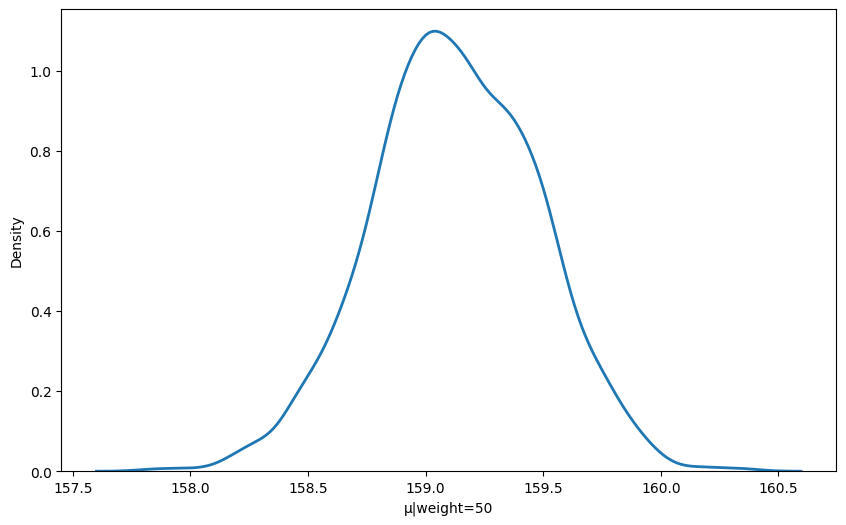

In [ ]:
# Posterior distribution of μ for weight=50
mu_at_50 = alpha_samples + beta_samples * (50 - x_bar)
plt.figure(figsize=(10, 6))
sns.kdeplot(mu_at_50, linewidth=2)
plt.xlabel("μ|weight=50")
plt.show()

In [ ]:
# Consider μ for a defined weight sequence
x_seq = np.arange(25, 71)
mu_seq = np.zeros((1000, len(x_seq)))

for j in range(1000):
    for i, x in enumerate(x_seq):
        mu_seq[j, i] = alpha_samples[j] + beta_samples[j] * (x - x_bar)

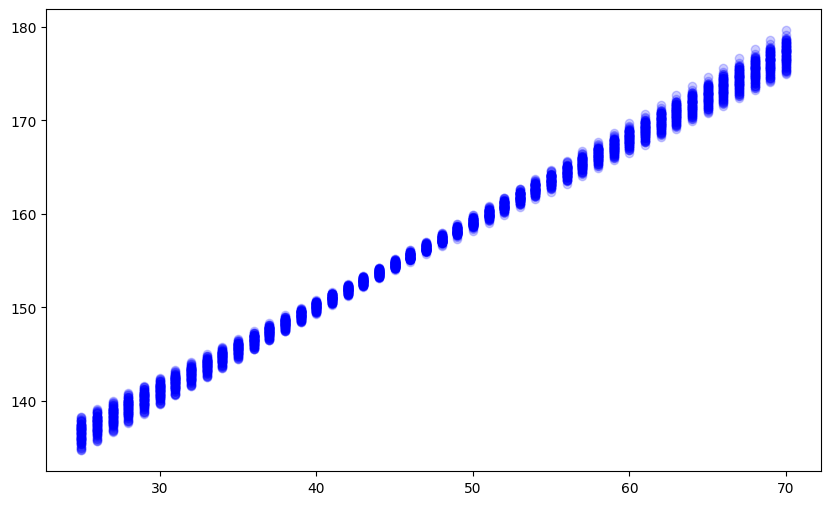

In [ ]:
# Plot sequences
plt.figure(figsize=(10, 6))
for j in range(100):
    plt.scatter(x_seq, mu_seq[j, :], color='blue', alpha=0.2)
plt.show()

In [ ]:
# Calculate mean and credible intervals
mu_seq_mean = np.zeros(len(x_seq))
mu_seq_CredI = np.zeros((len(x_seq), 2))

for i in range(len(x_seq)):
    mu_seq_mean[i] = np.mean(mu_seq[:, i])
    mu_seq_CredI[i, :] = CredI(mu_seq[:, i])

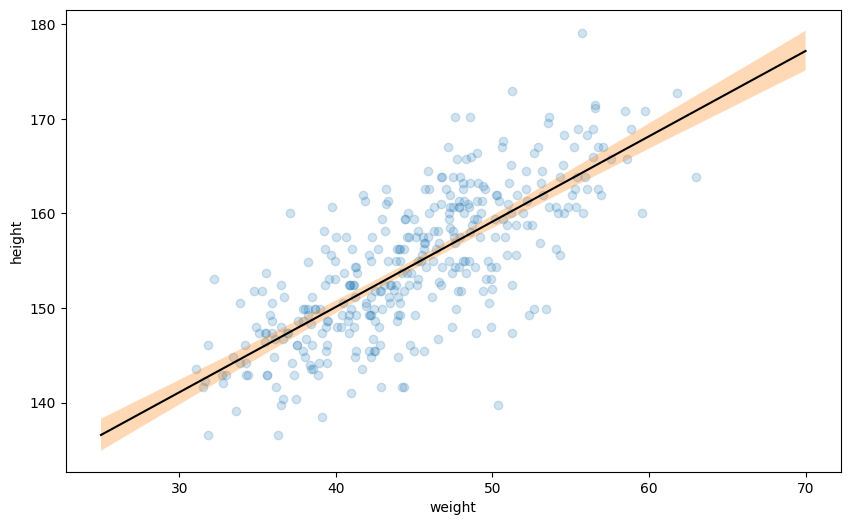

In [ ]:
# Plot with credible intervals
plt.figure(figsize=(10, 6))
plt.scatter(d2.weight, d2.height, alpha=0.2)
plt.xlabel("weight")
plt.ylabel("height")
plt.plot(x_seq, mu_seq_mean, color='black')
plt.fill_between(x_seq, mu_seq_CredI[:, 0], mu_seq_CredI[:, 1], alpha=0.3)

In [ ]:
# Simulate heights
sim_height = np.zeros((1000, len(x_seq)))

for j in range(1000):
    for i, x in enumerate(x_seq):
        mu = alpha_samples[j] + beta_samples[j] * (x - x_bar)
        sim_height[j, i] = np.random.normal(mu, sigma_samples[j])

In [ ]:
# Calculate credible intervals for simulated heights
height_CredI = np.zeros((len(x_seq), 2))

for i in range(len(x_seq)):
    height_CredI[i, :] = CredI(sim_height[:, i])

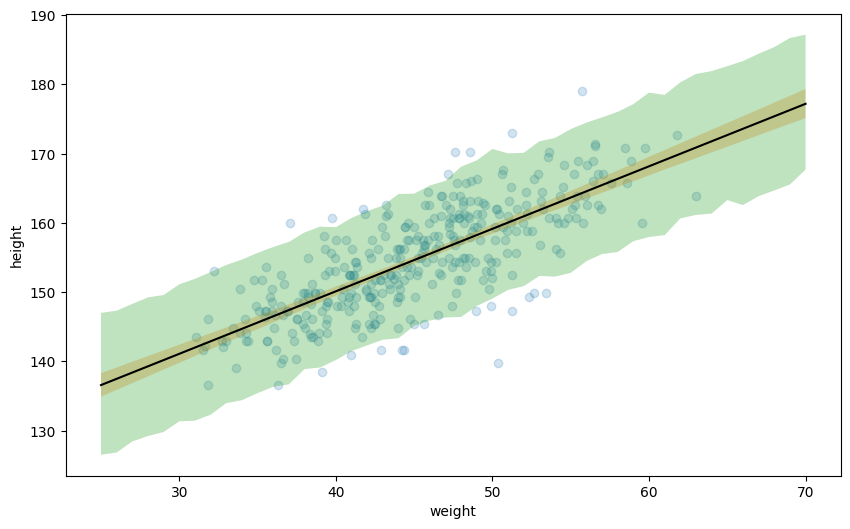

In [ ]:
# Plot with prediction intervals
plt.figure(figsize=(10, 6))
plt.scatter(d2.weight, d2.height, alpha=0.2)
plt.xlabel("weight")
plt.ylabel("height")
plt.plot(x_seq, mu_seq_mean, color='black')
plt.fill_between(x_seq, mu_seq_CredI[:, 0], mu_seq_CredI[:, 1], alpha=0.3)

plt.fill_between(x_seq, height_CredI[:, 0], height_CredI[:, 1], alpha=0.3)
plt.show()